In [1]:
# Основные фреймворки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализации
import matplotlib
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

In [3]:
# Импорт используемых фреймворков
from phik import phik_matrix

------------
### Первичный анализ данных

In [4]:
# Загрузка данных
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
# Размер данных
df.shape

(200, 6)

#### Описание признаков
- age - возраст
- sex - пол
- BP - давление
- Cholesterol - Уровни холестерина
- Na_to_K - Соотношение Na к калию

In [6]:
# Типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [7]:
# Уникальные значения 
df.nunique()

Age             57
Sex              2
BP               3
Cholesterol      2
Na_to_K        198
Drug             5
dtype: int64

- Признаки Sex, BP, Cholesterol, Drug имеют дискретные значения 
- Age,  Na_to_K представляют непрерывный тип данных

In [8]:
# непрерывные и дискретные признаки
continuous_сol = ['Age', 'Na_to_K']
discrete_col = ['Sex', 'BP', 'Cholesterol']
target_col = ['Drug']

In [9]:
# Пропуски значений
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

В данных отсутствуют пропуски.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


#### Анализ целевого признака


In [11]:
def viz_discr(feature):
    # Функция визуализации дискретных признаков
    print(f'Процентное соотношение классов в признаке {feature}')
    print(100 * df[feature].value_counts() / len(df))
    
    plt.figure(figsize=(8,5))
    sns.countplot(df[feature])
    plt.tight_layout()

Процентное соотношение классов в признаке Drug
DrugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: Drug, dtype: float64


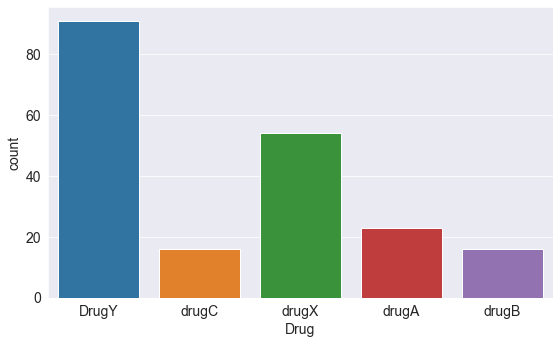

In [12]:
viz_discr('Drug')

В целевом признаке наблюдается дисбаланс классов. DrugY составляет 45.5% от всех данных, drugX составляет 27%, drugA - 11.5%, drugB и drugC составляют 8%.

#### Анализ дискретных признаков

Процентное соотношение классов в признаке Sex
M    52.0
F    48.0
Name: Sex, dtype: float64


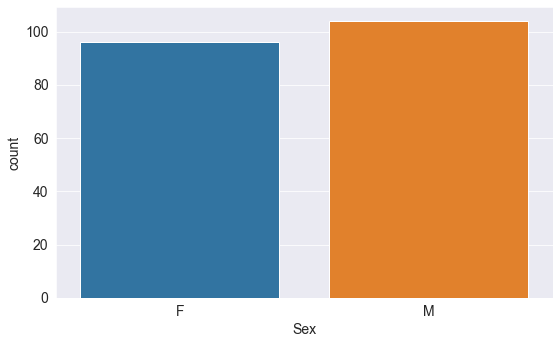

In [13]:
# SEX
viz_discr('Sex')

- Дисбаланс в признаке отсутсвует.
- В предобработке признак можно привести к бинарному виду [0, 1].

Процентное соотношение классов в признаке BP
HIGH      38.5
LOW       32.0
NORMAL    29.5
Name: BP, dtype: float64


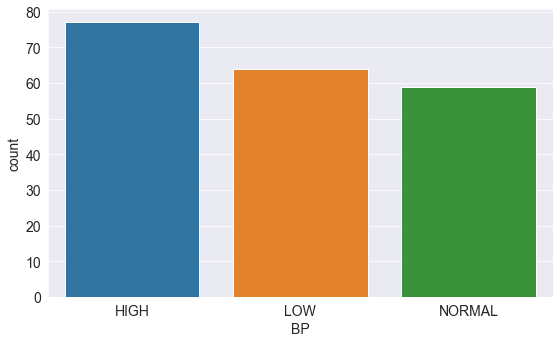

In [14]:
# BP
viz_discr('BP')

- Дисбаланса в распределении классов признака Давление не наблюдается. Но наибольшее количество наблюдений фиксировало высокий уровень кровяного давления.
- В предобработке признак можно привести к категориальному числовому виду.

Процентное соотношение классов в признаке Cholesterol
HIGH      51.5
NORMAL    48.5
Name: Cholesterol, dtype: float64


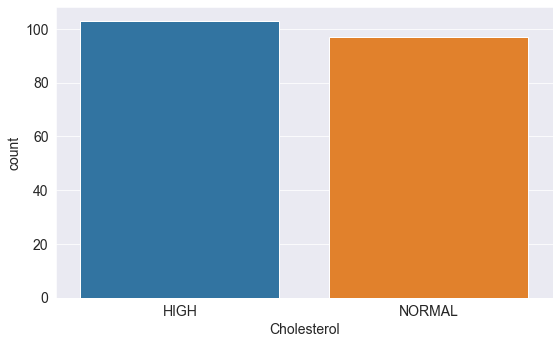

In [15]:
# Холестерин
viz_discr('Cholesterol')

- Дисбаланса в распределении классов признака Холестерин не наблюдается. Но наибольшее количество наблюдений фиксировало высокий уровень кровяного давления.
- В предобработке признак можно привести к категориальному бинарному виду [0, 1].

#### Анализ взаимодействия дискретных признаков c целевым признаком

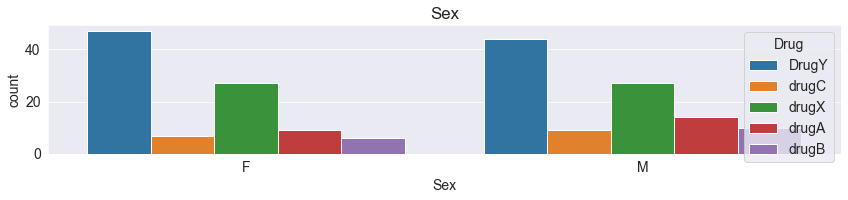

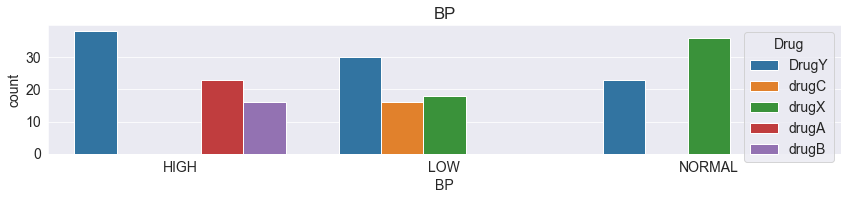

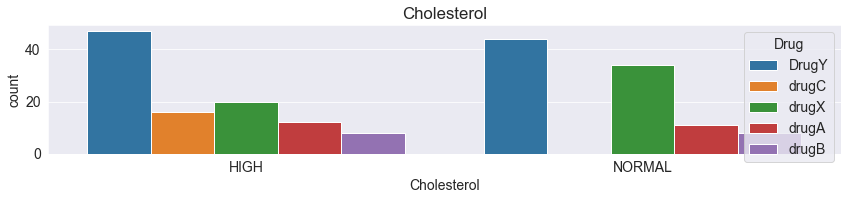

In [16]:
for feature in discrete_col:
    plt.figure(figsize=(12,3))
    sns.countplot(data=df, x=feature, hue='Drug')
    plt.title(feature)
    plt.tight_layout()

- Распределение Пола в зависмости от класса Наркотика почти не зависит.
- По распределению Кровяного давления видно, что drugC в основном фиксируется при низком BP, а drugB и drugА при высоком BP. Нормальное давление чаще всего фиксировалось при drugX.
- По распределению Холестерина видно, что drugC в основном наблюдается при высоком уровне Холестерина, а drugX чаще фиксировался при нормальном уровне Холестерина. Остальные классы целевого признака не так зависимы от уровня Холестерина.

#### Анализ непрерывных признаков

In [57]:
def viz_cont(feature):
    print(F'Минимальный {feature}: {min(df[feature])}')
    print(F'Максимальный {feature}: {max(df[feature])}')
    plt.figure(figsize=(15,4))
    sns.distplot(df[feature], bins=50)
    plt.title(f'Распределение признака {feature}')
    plt.tight_layout()

    plt.figure(figsize=(15,4))
    sns.kdeplot(data=df, x=feature, hue='Drug')
    plt.title(f'Распределение признака {feature} c учетом целевого признака')
    plt.tight_layout()


Минимальный Age: 15
Максимальный Age: 74


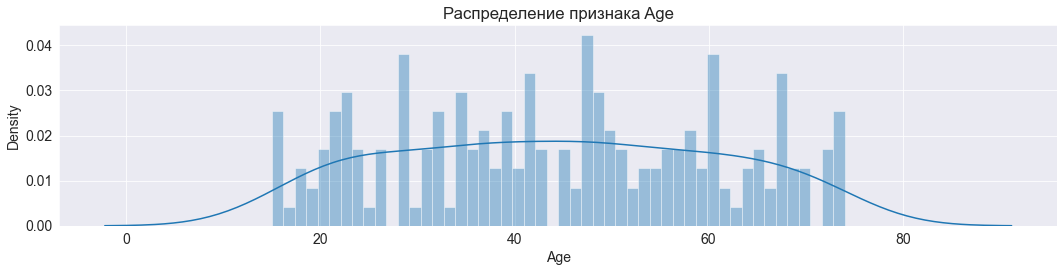

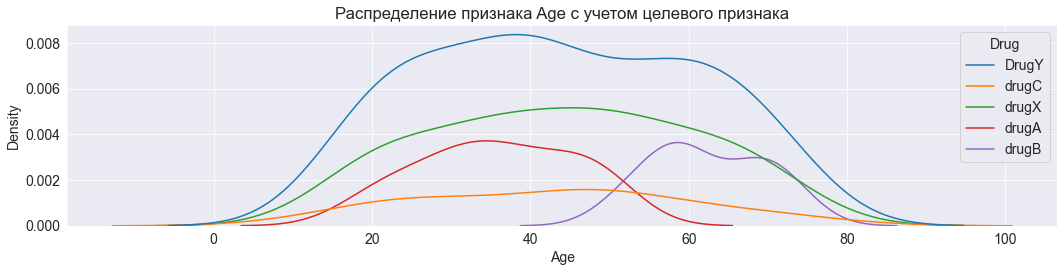

In [58]:
# Age
viz_cont('Age')

- Границы измерений [15, 74].
- Форма KDE напоминает плато
- Классы целевого признака drugY, dragX, drugC имеют распределение схожее с общим распределением признака Age
- Классы drugA и drugB имеют границы наблюдений уже

In [70]:
# Границы измерений drugA 
print('max Age drugA', max(df.loc[df.Drug=='drugA']['Age']))
print('min Age drugA', min(df.loc[df.Drug=='drugA']['Age']))
print('-----------------')
print('max Age drugB', max(df.loc[df.Drug=='drugB']['Age']))
print('min Age drugB', min(df.loc[df.Drug=='drugB']['Age']))

max Age drugA 50
min Age drugA 19
-----------------
max Age drugB 74
min Age drugB 51


Минимальный Na_to_K: 6.269
Максимальный Na_to_K: 38.247


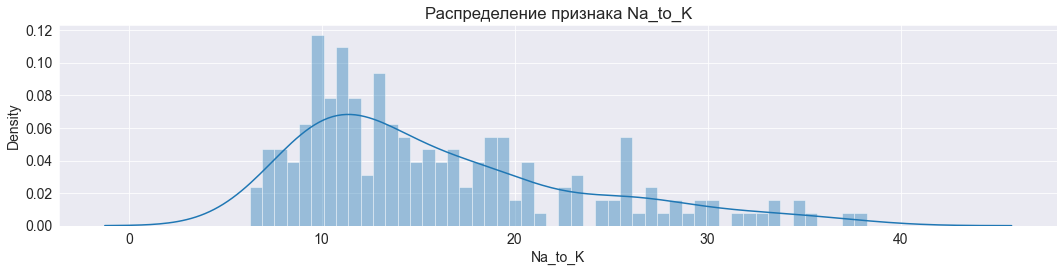

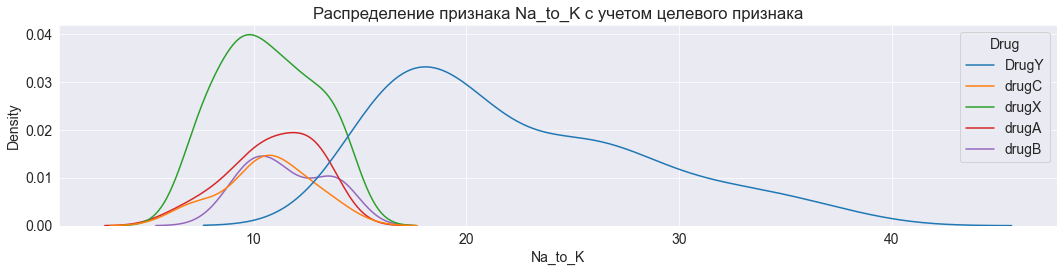

In [59]:
# Na_to_K
viz_cont('Na_to_K')